In [1]:
import os
import sys
## change the path of your owne latest version VITAE.
sys.path.append(r"/home/jinhongd/jingshu/VITAE-mm-pi-mm_added_pi/")

path_data = "/home/jinhongd/jingshu/VITAE-mm-pi-mm_added_pi/data"
path_weight = "weight/mouse.checkpoint"
path_result = 'result/'

import pandas as pd
import scanpy as sc
import numpy as np
import tensorflow as tf

import VITAE
from VITAE.utils import load_data, reset_random_seeds
from VITAE.utils import _get_smooth_curve


import networkx as nx

import importlib
#importlib.reload(VITAE)

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)},style = "white")

In [2]:
dd = load_data(path = path_data, file_name = "mouse_brain_merged")

sc.pp.normalize_total(dd, target_sum=1e4)
sc.pp.log1p(dd)
sc.pp.highly_variable_genes(dd, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(dd, max_value=10)

dd.obs.columns = ['grouping', 'S_Score', 'G2M_Score', 'Source']
dd.obs["Source"] = dd.obs["Source"].astype("category")

reset_random_seeds(400)
## Hyper parameters
npc = 64
model_type = "Gaussian"
hidden_layers = [32,16]
latent_space_dim = 8

clustering_res = 0.6
pi_prune_ratio = 0

n_posterior_samples = 10
beta = 1

model = VITAE.VITAE(adata = dd,
                 npc = npc, model_type = 'Gaussian',
                 hidden_layers = hidden_layers, latent_space_dim = latent_space_dim,
                 covariates = ['Source', 'S_Score', 'G2M_Score'])

model.load_model(path_weight, load_labels=True)

Initial clustering labels saved as 'vitae_init_clustering' in self.adata.obs.


'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs
Calculate UMAP ...
'vitae_new_clustering' updated based on the projected cell positions.
Cell projection uncertainties stored as 'projection_uncertainty' in self.adata.obs


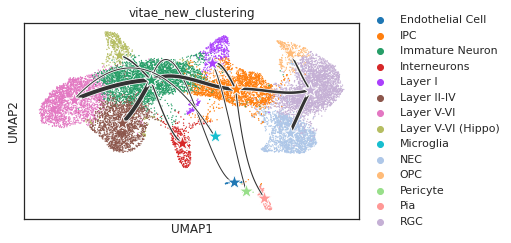

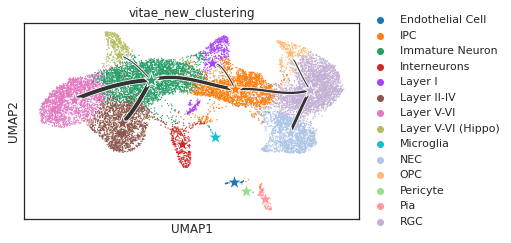

In [3]:
model.infer_backbone(cutoff = 0, no_loop = True, visualize = True,method = "raw_map")
a = list(model.backbone.edges(data = True))
a = [x[2]["weight"] for x in a]
a = np.sort(a)[-8] - 1e-10
model.infer_backbone(cutoff = a, no_loop = True, visualize = True,method = "raw_map")

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


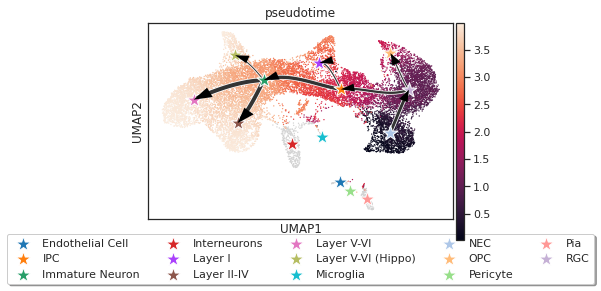

In [4]:
model.infer_trajectory("NEC")

# Figure 3a

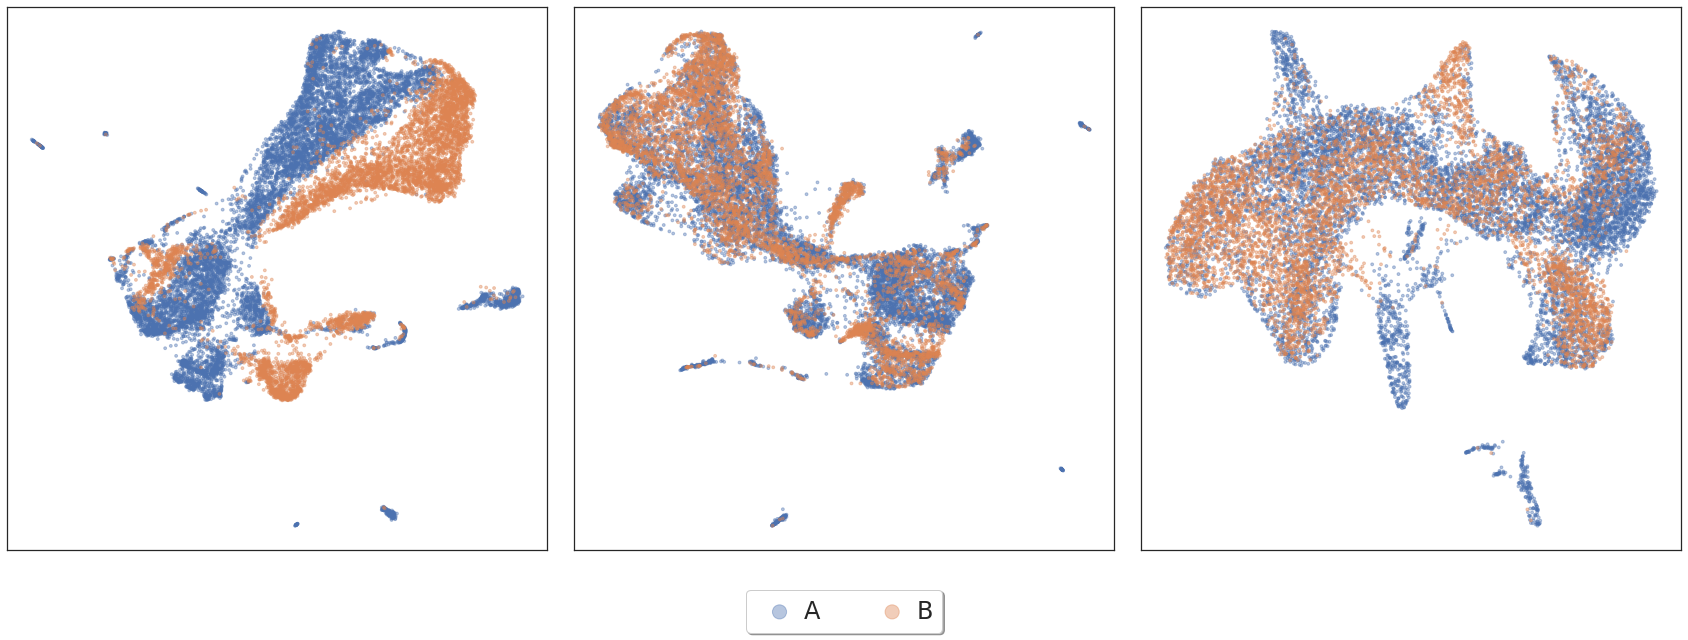

In [5]:
sns.color_palette()
labels = np.ones((len(model.labels)))
labels[:10261] = 0

color_ggplot_2 = sns.color_palette()[:2]
colors = np.array([color_ggplot_2[int(i)] for i in labels])     

fig, axes = plt.subplots(1,3, figsize=(30, 10))
df = pd.read_csv(os.path.join(path_result,'Seurat_unintegrated_unadjusted.csv'), index_col=[0])
axes[0].scatter(*df.values.T, c=colors,
    s=8, alpha=0.4)
plt.setp(axes[0], xticks=[], yticks=[])

df = pd.read_csv(os.path.join(path_result,'Seurat_integrated_adjusted.csv'), index_col=[0])
df['UMAP_1'] = -df['UMAP_1']
for i,x in enumerate(['A','B']):
    axes[1].scatter(*df.values[labels==i].T,
            c=colors[labels==i],
        s=8, alpha=0.4, label=x)
plt.setp(axes[1], xticks=[], yticks=[])
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, markerscale=5, ncol=9, handletextpad=0.01, prop={'size': 24})    
axes[2].scatter(*model._adata_z.obsm['X_umap'].T, c=colors,
    s=8, alpha=0.4)
plt.setp(axes[2], xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
plt.savefig("Figure3a.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Figure 3c

Cell projection uncertainties stored as 'pseudotime' in self.adata.obs


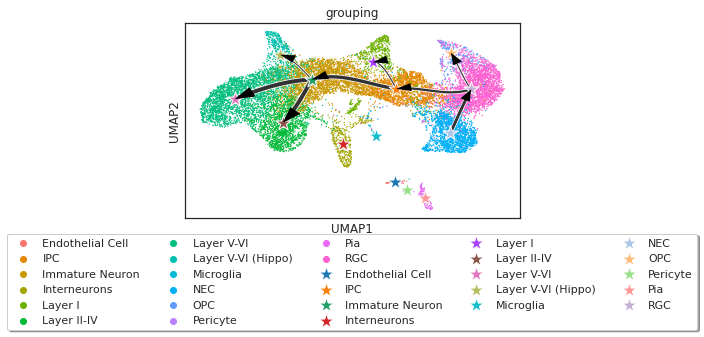

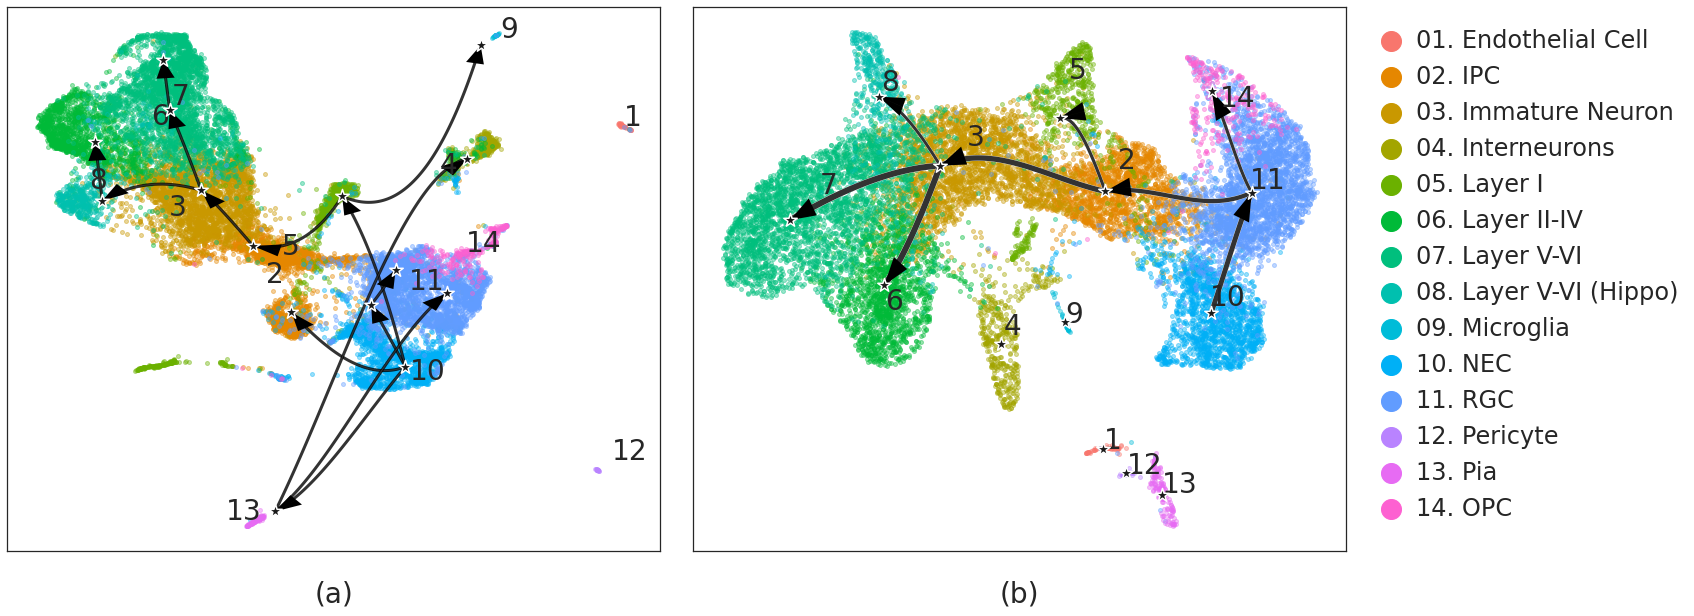

In [6]:
color_ggplot_15 = [
    "#F8766D", "#E58700", "#C99800", "#A3A500", "#6BB100", 
    "#00BA38", "#00BF7D", "#00C0AF", "#00BCD8", "#00B0F6", 
    "#619CFF", "#B983FF", "#E76BF3", "#FD61D1", "#FF67A4"
    ]

fig, ax = plt.subplots(1,1)
model.infer_trajectory(
    "NEC", color="grouping", ax=ax, palette=color_ggplot_15
)
plt.show()


df_slingshot = pd.read_csv(os.path.join(path_result,'Slingshot_cluster_network.csv'), index_col=[0])
df = pd.read_csv(os.path.join(path_result,"Seurat_clustering.csv"), index_col=[0])
cluster_labels = df.iloc[:,2].values - 1
uni_cluster_labels = np.unique(cluster_labels)

labels = model.labels
# labels[labels == 'Layer V-VI (Hippo)'] = 'Hippocampus'
uni_labels = np.unique(labels)
uni_labels[[10,13]] = uni_labels[[13,10]]

embed =  df.iloc[:,[0,1]].values
embed[:,0] = -embed[:,0]
NUM_Cluster_CLUSTER = len(uni_cluster_labels)
NUM_CLUSTER = len(uni_labels)

embed_mu = np.zeros((NUM_Cluster_CLUSTER,2))
for i,x in enumerate(uni_cluster_labels):
    embed_mu[i,:] = np.mean(embed[cluster_labels==x,:], axis=0, keepdims=True)
    if i==5:
        embed_mu[i,:] += [1.0, -1.5]
    elif i==10:
        embed_mu[i,:] += [2.0, 2.8]
    elif i==13:
        embed_mu[i,:] += [-3.5, -4.5]
    elif i==14:
        embed_mu[i,:] += [-0.5,-0.5]


G = nx.Graph()
G.add_nodes_from(np.unique(df_slingshot[['from', 'to']].values.flatten()))
G.add_weighted_edges_from(df_slingshot[['from', 'to','length']].values.tolist())



init_node = 5
connected_comps = nx.node_connected_component(G, init_node)
subG = G.subgraph(connected_comps)

milestone_net = model.inferer.build_milestone_net(subG,init_node)
select_edges = milestone_net[:,:2]


fig, axes = plt.subplots(1,2, figsize=(24, 10))
for i,x in enumerate(uni_labels):
    axes[0].scatter(*embed[labels==x].T, c=[color_ggplot_15[i]],
        s=16, alpha=0.4, label=str(x))
    dx = dy =0
    if i==1:
        dx = -0.5,
        dy = -0.5
    elif i==3:
        dx = -1.0
        dy = -1.0
    elif i==5:
        dx = 1.5
        dy = 0.5
    elif i==9:
        dx = 0.7
        dy = -1.5
    elif i==10:
        dx = -0.3
    
    elif i==11:
        dx = 0.5
        dy = 0.5
    elif i==2:
        dx = -1.0
        dy = -1.0
    elif i==12:
        dx = -1.0
        dy = 0.0

    axes[0].text(np.mean(embed[labels==x,0])+dx, 
             np.mean(embed[labels==x,1])+dy, str(i+1), fontsize=28)

axes[0].scatter(*embed_mu.T, s=200, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)

for i in range(len(select_edges)):
    points = embed[(cluster_labels==select_edges[i,0])|(cluster_labels==select_edges[i,1]),:]
    points = points[points[:,0].argsort()]    
    points = points[~(
        (np.sum(points < embed_mu[select_edges[i,0], :], axis=-1)==2) & 
        (np.sum(points < embed_mu[select_edges[i,1], :], axis=-1)==2)
        ),:]
    points = points[~(
        (np.sum(points > embed_mu[select_edges[i,0], :], axis=-1)==2) & 
        (np.sum(points > embed_mu[select_edges[i,1], :], axis=-1)==2)
        ),:]
    if i==7:
        fixed_points = np.r_[embed_mu[select_edges[i,0:1], :], 
                             np.mean(embed_mu[select_edges[i,:], :],axis=0,keepdims=True)+[-0.5,0.5],
                             embed_mu[select_edges[i,1:2], :]
                             ]
    else:
        fixed_points = embed_mu[select_edges[i,:], :]
    x_smooth, y_smooth = _get_smooth_curve(
        points, 
        fixed_points,
        [np.min(embed[:,1]),np.max(embed[:,1])]
        )
    axes[0].plot(x_smooth, y_smooth, 
        '-', 
        linewidth= 3,
        color="black", 
        alpha=0.8, 
        path_effects=[pe.Stroke(linewidth=1, 
                                foreground='white'), pe.Normal()],
        zorder=1
        )

    if i==7:
        delta_x = embed_mu[select_edges[i,1], 0]-x_smooth[-15]
        delta_y = embed_mu[select_edges[i,1], 1]-y_smooth[-15]
    else:
        delta_x = embed_mu[select_edges[i,1], 0]-x_smooth[-2]
        delta_y = embed_mu[select_edges[i,1], 1]-y_smooth[-2]
    length = np.sqrt(delta_x**2 + delta_y**2) * 1.5                
    axes[0].arrow(
            embed_mu[select_edges[i,1], 0]-delta_x/length, 
            embed_mu[select_edges[i,1], 1]-delta_y/length, 
            delta_x/length,
            delta_y/length,
            color='black', alpha=1.0,
            shape='full', lw=0, length_includes_head=True, head_width=0.6, zorder=2)
    
    

# our method
root = 'NEC'
method = 'UMAP'
dict_label_num = {j:i for i,j in model.labels_map['label_names'].to_dict().items()}
uni_cluster_labels = model.adata.obs['vitae_new_clustering'].cat.categories
cluster_labels = model.adata.obs['vitae_new_clustering'].to_numpy()
embed_z = model._adata.obsm[model.dict_method_scname[method]]
embed_mu = np.zeros((len(uni_cluster_labels), 2))
for l in uni_cluster_labels:
    embed_mu[dict_label_num[l],:] = np.mean(embed_z[cluster_labels==l], axis=0)

for i,x in enumerate(uni_labels):
    axes[1].scatter(*embed_z[labels==x].T, c=[color_ggplot_15[i]],
        s=16, alpha=0.4, label='%02d'%(i+1)+'. '+str(x))
    
    dx = dy =0
    if i==1:
        dy= 1
    elif i == 2:
        dx = -0.0
        dy = 1
    elif i in [4]:
        dy = 2
    elif i == 5:
        dy = -1
    elif i in [6,7]:
        dy = 0.5
    axes[1].text(np.mean(embed_z[labels==x,0])+dx, 
            np.mean(embed_z[labels==x,1])+dy, str(i+1), fontsize=28)
axes[1].scatter(*embed_mu.T, s=200, color='k', marker='*',
                                linewidth=1.5, edgecolor='white', zorder=3)


graph = model.directed_backbone
select_edges = list(graph.edges)
select_edges_score = np.array([d['weight'] for (u,v,d) in graph.edges(data=True)])
if max(select_edges_score) - min(select_edges_score) == 0:
    select_edges_score = select_edges_score/max(select_edges_score)
else:
    select_edges_score = (select_edges_score - min(select_edges_score))/(max(select_edges_score) - min(select_edges_score))*3

#   colors = [plt.cm.jet(float(i)/self.n_states) for i in range(self.n_states)]
value_range = np.maximum(np.diff(axes[1].get_xlim())[0], np.diff(axes[1].get_ylim())[0])
y_range = np.min(embed_z[:,1]), np.max(embed_z[:,1], axis=0)
 
for i in range(len(select_edges)):
    points = embed_z[np.sum(model.cell_position_projected[:,select_edges[i]]>0, axis=-1)==2,:]
    points = points[points[:,0].argsort()]          
    x_smooth, y_smooth = _get_smooth_curve(
        points, 
        embed_mu[select_edges[i], :],
        y_range
        )
    axes[1].plot(x_smooth, y_smooth, 
        '-', 
        linewidth= 3 + select_edges_score[i],
        color="black", 
        alpha=0.8, 
        path_effects=[pe.Stroke(linewidth=2+select_edges_score[i]+1.5, 
                                foreground='white'), pe.Normal()],
        zorder=1
        )

    delta_x = embed_mu[select_edges[i][1], 0]-x_smooth[-2]
    delta_y = embed_mu[select_edges[i][1], 1]-y_smooth[-2]
    length = np.sqrt(delta_x**2 + delta_y**2) * 50           
    axes[1].arrow(
            embed_mu[select_edges[i][1], 0]-delta_x/length, 
            embed_mu[select_edges[i][1], 1]-delta_y/length, 
            delta_x/length,
            delta_y/length,
            color='black', alpha=1.0,
            shape='full', lw=0, length_includes_head=True, head_width=0.8, zorder=2)



box = axes[1].get_position()
axes[1].set_position([box.x0 + box.width*0.1, box.y0,
                    box.width * 0.9, box.height])
leg = axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1.0),
            fancybox=False, shadow=False, markerscale=5, ncol=1, 
            frameon=False, handletextpad=0.01,
            prop={'size': 24})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
axes[0].set_xlabel('(a)', fontsize=28, labelpad=30)
axes[1].set_xlabel('(b)', fontsize=28, labelpad=30)
plt.setp(axes[0], xticks=[], yticks=[])
plt.setp(axes[1], xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
plt.savefig("Figure3b.png", dpi=300, bbox_inches='tight', pad_inches=0.05)    

# Figure S3a

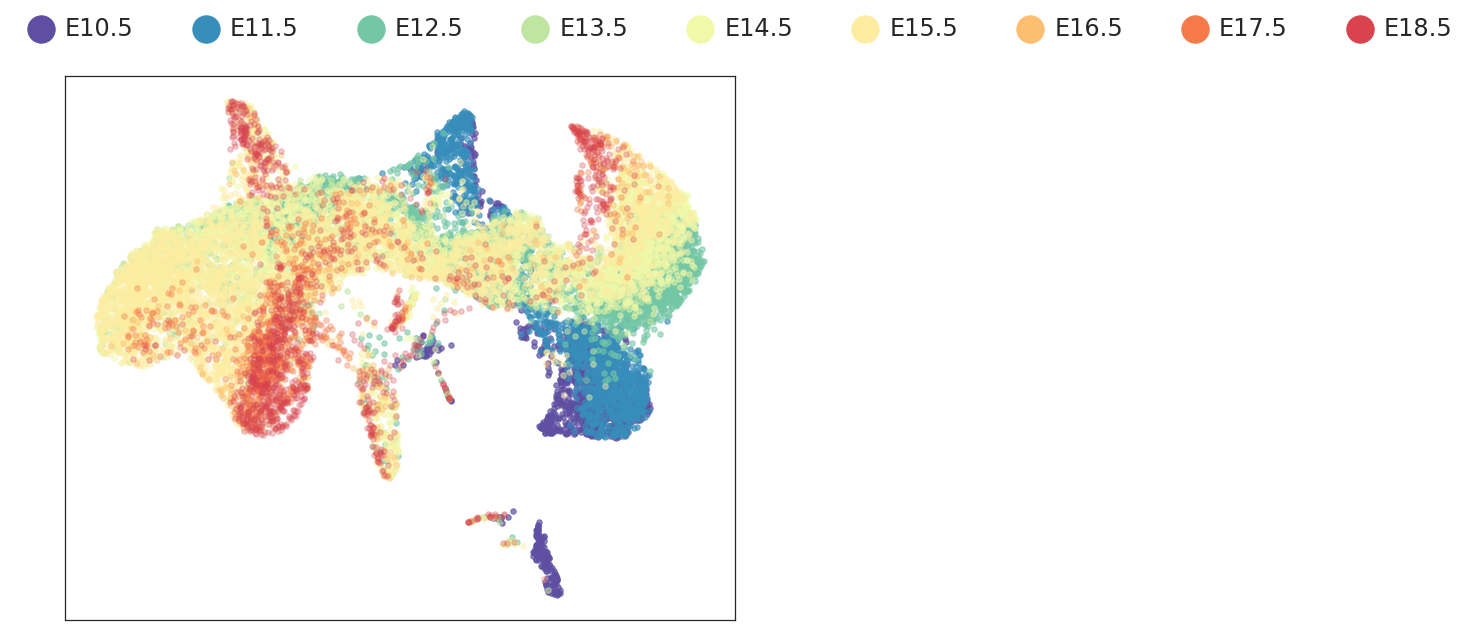

In [7]:
labels = np.array([i[:3] for i in np.array(dd.obs.index)])
n_labels = len(np.unique(labels))
colors = [plt.cm.Spectral_r(float(i)/n_labels) for i in range(n_labels)]

fig, ax = plt.subplots(1,1, figsize=(12, 10))
for i,x in enumerate(np.unique(labels)):
    ax.scatter(*embed_z[labels==x].T, c=[colors[i]],
        s=30, alpha=0.7-i*0.05, label=str(x)+'.5'
        )
    
box = ax.get_position()
ax.set_position([box.x0 + box.width*0.1, box.y0,
                    box.width * 0.9, box.height])
leg = ax.legend(loc='upper center', bbox_to_anchor=(1.0, 1.15),
            fancybox=False, shadow=False, markerscale=5, ncol=100, 
            frameon=False, handletextpad=0.01,
            prop={'size': 24})
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.setp(ax, xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=None)
plt.savefig("FigureS3a.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Figure 3b

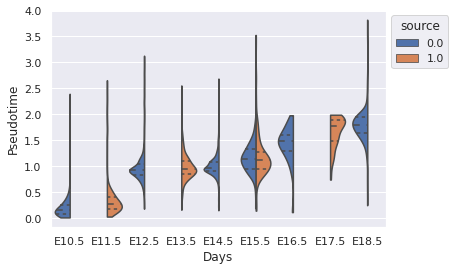

In [8]:
days = np.char.add([x[:3] for x in dd.obs.index], '.5')
model.adata.obs["days"] = days.copy()
model._adata.obs["days"] = days.copy()

sources = np.ones((len(model.labels)))
sources[:10261] = 0

id_cell = model.adata.obs['grouping'].isin(['NEC','RGC','OPC'])
df = pd.DataFrame({'pseudotime':model.pseudotime[id_cell],'day':days[id_cell],'source':sources[id_cell]})

sns.set()
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.violinplot(data=df, x="day", y="pseudotime", hue="source", split=True,
               cut=0, saturation=0.9, inner='quartile', legend=False,
               order=np.unique(days), ax=ax)
ax.set_xlabel('Days')
ax.set_ylabel('Pseudotime')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("Figure3c.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Figure S3b

/home/jinhongd/anaconda3/envs/vitae/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'days' as categorical


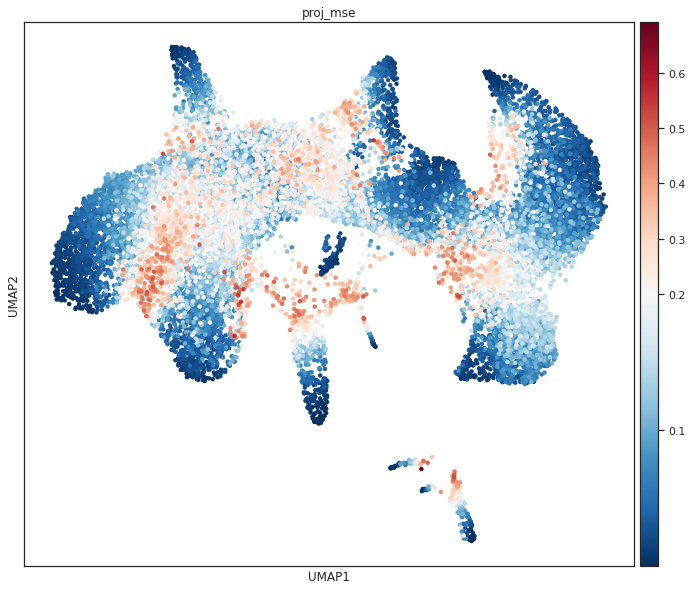

In [9]:
proj_mse = np.sum((model.cell_position_projected - model.cell_position_posterior)**2,axis = 1) + np.sum(model.cell_position_variance, axis = 1)

model.adata.obs["proj_mse"] = proj_mse
model._adata.obs["proj_mse"] = proj_mse

sns.set(rc={'figure.figsize':(12,10)},style = "white")
model.visualize_latent(color=["proj_mse"],size = 80,color_map = "RdBu_r", 
                       vcenter=0.2,show=False)
plt.savefig("FigureS3b.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Figure S3c

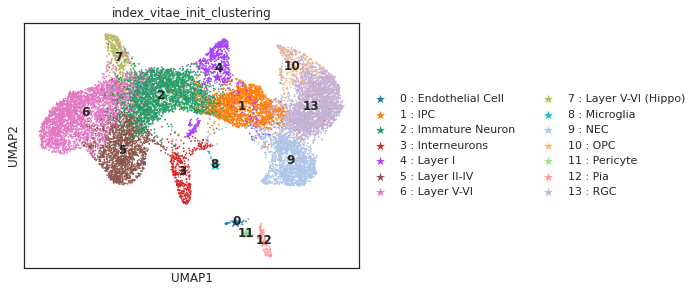

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
model.plot_center(color='vitae_init_clustering', size=12, font_size=12, ax=ax)
plt.savefig("FigureS3c.png", dpi=300, bbox_inches='tight', pad_inches=0.05)

# Figure S3d

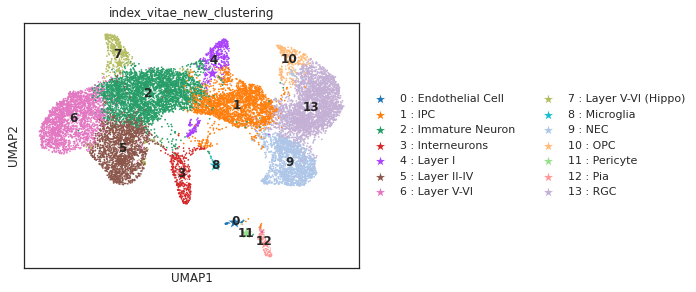

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
model.plot_center(size=12, font_size=12, ax=ax)
plt.savefig("FigureS3d.png", dpi=300, bbox_inches='tight', pad_inches=0.05)